In [1]:
import os
import sys

def add_to_sys_path(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        sys.path.append(dirpath)        
root_dir = '/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/'
add_to_sys_path(root_dir)

from FFNNmodel import FeedforwardNeuralNetwork, ffnn_train, ffnn_evaluate, ffnn_predict
from neural_audio_dataset import NeuralAudioDataset
import utils.audio_utils as au
import utils.encodec_utils as eu
import utils.signal_utils as su
import utils.train_utils as tu
import utils.visualization_utils as vu

import argparse
import json
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import mean_squared_error

exec(open('/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/utils/all_imports.py').read())

In [2]:
def load_model_statedict(models_checkpoints_dir, model_filename):
    
    # --------- LOAD EXPERIMENT --------- #
    
    # Path for the CSV file
    info_path = os.path.join(models_checkpoints_dir, 'models_info.csv')
    
    # Check if the file exists and 
    if os.path.isfile(info_path):
        df_models = pd.read_csv(info_path)
        idx = df_models[df_models['model_name'].apply(lambda x: x in model_filename)].index
    
    if not idx.empty:
        dataset_filename = df_models.loc[idx]['dataset_filename'].values[0]
        config_filepath = df_models.loc[idx]['config_filepath'].values[0]
        config_id = df_models.loc[idx]['config_id'].values[0]
        train_idxs = eval(df_models.loc[idx]['train_idxs'].values[0])
        test_idxs = eval(df_models.loc[idx]['test_idxs'].values[0])
        model_layers = eval(df_models.loc[idx]['layers'].values[0])
    else: 
        print('Index not found.')
        return
    
    print('train_idxs: ', train_idxs, ' - test_ixs: ', test_idxs, ' - model_layers: ', model_layers)

    # --------- EXPERIMENT CONFIG --------- #
    
    # Extract experiment params from JSON config file
    with open(config_filepath, 'r') as file:
            configs = json.load(file)  
    data_dir = configs['common_dirs']['dataset_dir']
    neural_mode = configs['common_params']['neural_mode']
    
    # Find the run configuration corresponding to the experiment of interest
    run_idx = next((i for i in range(len(configs['runs'])) if configs['runs'][i]['id'] == config_id), -1)
    conf = configs['runs'][run_idx]
    # Experiment params
    config_id = conf['id']
    neural_key = conf['neural_key']    
    # Data_processing_params
    neural_history_ms = conf['data_processing_params']["neural_history_ms"]
    gaussian_smoothing_sigma = conf['data_processing_params']["gaussian_smoothing_sigma"]    
    # Data_augmentation_params
    max_temporal_shift_ms = conf['data_augmentation_params']["max_temporal_shift_ms"]
    noise_level = conf['data_augmentation_params']["noise_level"]
    transform_probability = conf['data_augmentation_params']["transform_probability"]    
    # Model_params
    hidden_layer_sizes = conf['model_params']["hidden_layer_sizes"]
    dropout_prob = conf['model_params']["dropout_prob"]
    # Training_params
    batch_size = conf['training_params']["batch_size"]
    learning_rate = conf['training_params']["learning_rate"]
    
    
    # --------- LOAD DATA --------- #
        
    # Open the file in binary read mode ('rb') and load the content using pickle
    with open(data_dir + dataset_filename + '.pkl', 'rb') as file:
        data_dict = pkl.load(file)
    
    # Extarct data from dataset
    neural_array = data_dict['neural_dict'][neural_key]
    audio_motifs = data_dict['audio_motifs']
    fs_audio = data_dict['fs_audio']
    fs_neural = data_dict['fs_neural']
    
    # Calculate the duration based on the last dimension of the arrays and their sampling rates
    trial_length_neural = (neural_array.shape[-1] / fs_neural)*1000
    trial_length_audio = (audio_motifs.shape[-1] / fs_audio)*1000
    
    # Check the durations of the neural/audio data are equal and raise a warning if they aren't
    print('Length of neural trials: {} ms, length of audio trials: {} ms. '.format(trial_length_neural, trial_length_audio))
    if trial_length_neural != trial_length_audio:
        warnings.warn("WARNING: Neural data duration and audio motifs duration are different in this dataset!")
    
    # --------- PROCESS AUDIO --------- #
        
    b, a = fh.load_filter_coefficients_matlab(
        '/home/jovyan/pablo_tostado/repos/songbirdcore/songbirdcore/filters/butter_bp_250Hz-8000hz_order4_sr25000.mat')
    audio_motifs = fh.noncausal_filter_2d(audio_motifs, b=b, a=a)
    
    # Reduce noise
    for m in range(len(audio_motifs)):
        audio_motifs[m] = nr.reduce_noise(audio_motifs[m], sr=fs_audio)
    
    # --------- INSTANTIATE ENCODEC --------- #
    
    # Instantiate a pretrained EnCodec model
    encodec_model = EncodecModel.encodec_model_48khz()
    # bandwidth = 24kbps for 48kHz model (n_q=16)
    encodec_model.set_target_bandwidth(24.0)
    
    # Embed motifs
    audio_embeddings, audio_codes, scales = eu.encodec_encode_audio_array_2d(audio_motifs, fs_audio, encodec_model)
    
    # --------- PROCESS NEURAL --------- #
    
    # Resample neural datato match audio embeddings
    samples_neural = neural_array.shape[2]
    samples_embeddings = audio_embeddings.shape[2]
    history_size = samples_neural//samples_embeddings
    
    # Match neural to audio samples (! Different for raw spiketrains vs trajectories)
    if neural_mode == 'RAW':
        print('Pre-processing neural data as RAW')
        # Gaussian kernel along the temporal dimension of the spiketrains
        neural_array = gaussian_filter1d(neural_array, sigma=gaussian_smoothing_sigma, axis=2) 
        # Downsample to spikerate at given bin_size
        neural_array = sh.downsample_list_3d(neural_array, history_size, mode='sum')  
    elif neural_mode == 'TRAJECTORIES':
        print('Pre-processing neural data as TRAJECTORIES')
        # Downsample by interpolation
        neural_array = np.array([su.resample_by_interpolation_2d(n, samples_neural, samples_embeddings) for n in neural_array])
    else:
        raise ValueError("Neural mode must be 'RAW' or 'TRAJECTORIES'")
    
    bin_length = trial_length_neural / neural_array.shape[2] # ms
    history_size = int(neural_history_ms // bin_length) # Must be minimum 1
    print('Using {} bins of neural data history.'.format(history_size))
    
    # --------- PREPARE DATALOADERS --------- #
    
    # Split the data into train and test sets
    train_neural = neural_array[train_idxs]  
    train_audio = audio_embeddings[train_idxs]
    test_neural = neural_array[test_idxs]  
    test_audio = audio_embeddings[test_idxs]
    
    # Create dataset objects
    max_temporal_shift_bins = int(max_temporal_shift_ms // bin_length) # Temporal jitter for data augmentation
    
    train_dataset = NeuralAudioDataset(train_neural, 
                                       train_audio, 
                                       history_size, 
                                       max_temporal_shift=max_temporal_shift_bins,
                                       noise_level=noise_level,
                                       transform_probability=transform_probability)
    
    test_dataset = NeuralAudioDataset(test_neural, 
                                      test_audio, 
                                      history_size, 
                                      max_temporal_shift=0,
                                      noise_level=0,
                                      transform_probability=0)
    
    print('Train samples: ', len(train_dataset))
    print('Test samples: ', len(test_dataset))
    
    # Prepare data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # --------- LOAD MODEL --------- #
    
    # Define the paths for the model checkpoint
    model_checkpoint_path = model_filename
    
    # Load the model and optimizer's state dicts from the checkpoint
    checkpoint = torch.load(model_checkpoint_path)
    ffnn_model = FeedforwardNeuralNetwork(model_layers)
    ffnn_model.load_state_dict(checkpoint['model_state_dict'])
    
    optimizer = optim.AdamW(ffnn_model.parameters(), lr=learning_rate)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales

In [3]:
def get_original_reconstructed_audio(ffnn_model, dataset, loader, fs_audio, encodec_model, scale):
    
    # ORIGINAL AUDIO
    it = iter(dataset)
    samples = []
    for _ in range(len(dataset)):
        sample = next(it)
        samples.append(sample[1])  # assuming sample[1] is the tensor of interest
    original_embeddings = torch.stack(samples, dim=0).permute(1,0)
    original_audio = eu.audio_from_embedding(original_embeddings, scale, encodec_model, fs_audio).squeeze(0).squeeze(0)

    # DECODED AUDIO
    decoded_embeddings, error = ffnn_predict(ffnn_model, loader)
    decoded_embeddings = decoded_embeddings.permute(1, 0)
    
    decoded_embeddings = decoded_embeddings.to(scale.device)
    decoded_audio = eu.audio_from_embedding(decoded_embeddings, scale, encodec_model, fs_audio).squeeze(0).squeeze(0)

    return original_audio.detach().numpy(), decoded_audio.detach().numpy()

In [4]:
def plot_spectrogram(audio, fs_audio, plot_samples):

    fig, ax = plt.subplots(nrows=1, figsize=(10, 3))
    auts.plot_spectrogram(audio[:plot_samples], fs_audio, ax, f_min=500, f_max=8500)
    ax.set_xlabel('time (s)', fontsize=30)
    ax.tick_params(axis='x', labelsize=25)
    ax.set_ylabel('f (kHz)', fontsize=30)
    ax.set_yticklabels(['0', '2', '4', '6', '8'], fontsize=25)

In [5]:
models_checkpoints_dir = "/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models_checkpoints/"
file_extension = "pt"

model_filenames = [file for file in glob.glob(f"{models_checkpoints_dir}*.{file_extension}")]
display(model_filenames)

['/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models_checkpoints/ffnn_model_ra_all_RAW_z_w12m7_20_20240325_210721_config1.pt',
 '/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models_checkpoints/ffnn_model_hvc_all_RAW_z_r12r13_21_20240328_185716_config2.pt',
 '/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models_checkpoints/ffnn_model_ra_all_RAW_z_r12r13_21_20240328_185716_config1.pt',
 '/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models_checkpoints/ffnn_model_ra_all_TRAJECTORIES_z_r12r13_21_20240328_191239_config1.pt',
 '/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models_checkpoints/ffnn_model_hvc_all_TRAJECTORIES_z_r12r13_21_20240328_191239_config2.pt',
 '/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models_checkpoints/ffnn_model_ra_all_TRAJECTORIES_z_w12m7_20_20240326_201101_config1.pt',
 '/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models_checkpoints/ffnn_model_hvc_all_TR

Loading model:  /home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models_checkpoints/ffnn_model_hvc_all_RAW_z_w12m7_20_20240325_210721_config2.pt
train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7]  - test_ixs:  [8, 9]  - model_layers:  [228, 64, 128]
Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 
Pre-processing neural data as RAW
Using 2 bins of neural data history.
Train samples:  808
Test samples:  206
Loading model:  /home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models_checkpoints/ffnn_model_ra_all_RAW_z_w12m7_20_20240325_210721_config1.pt
train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7]  - test_ixs:  [8, 9]  - model_layers:  [344, 64, 128]
Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 
Pre-processing neural data as RAW
Using 2 bins of neural data history.
Train samples:  808
Test samples:  206
Loading model:  /home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models_checkpoints/ffnn_model_hvc_all_TRAJECTORIES_z_w12m7_20_2024

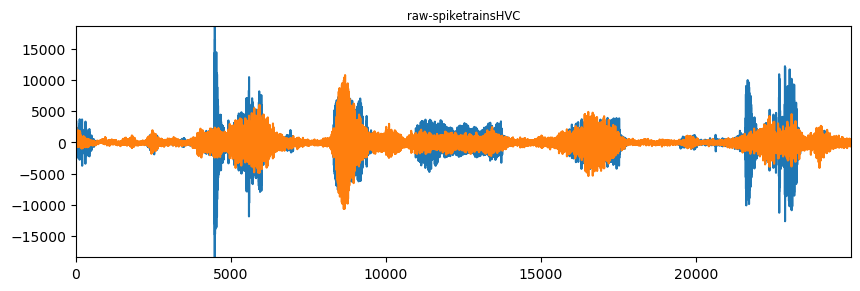

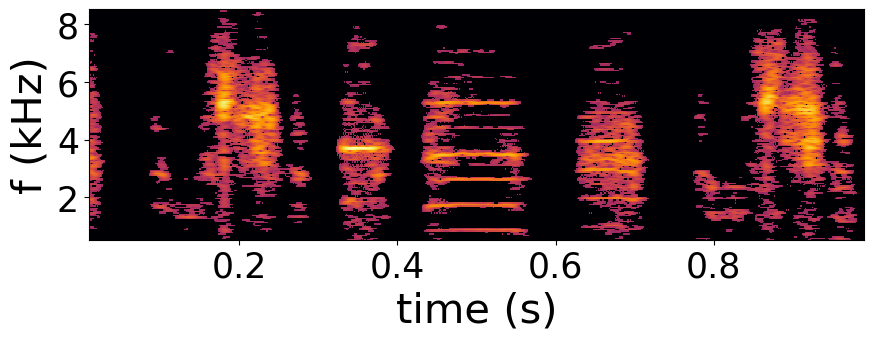

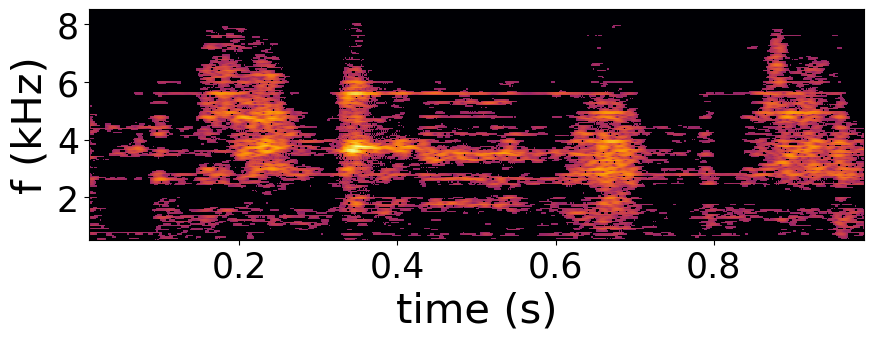

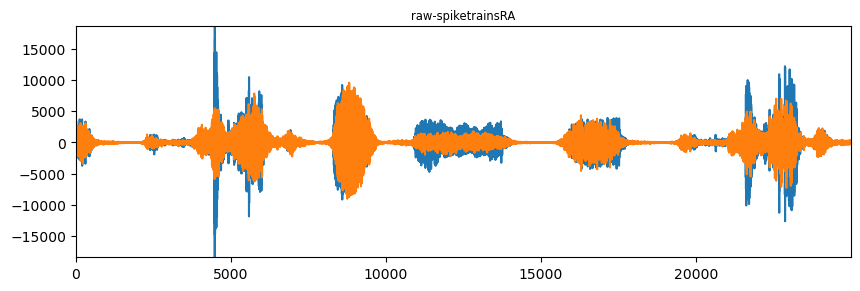

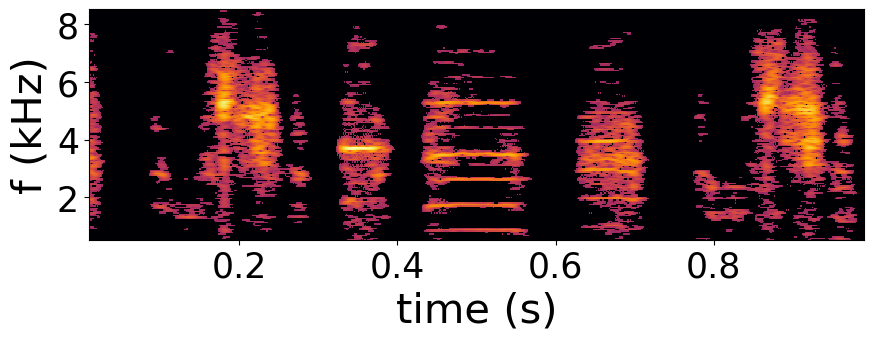

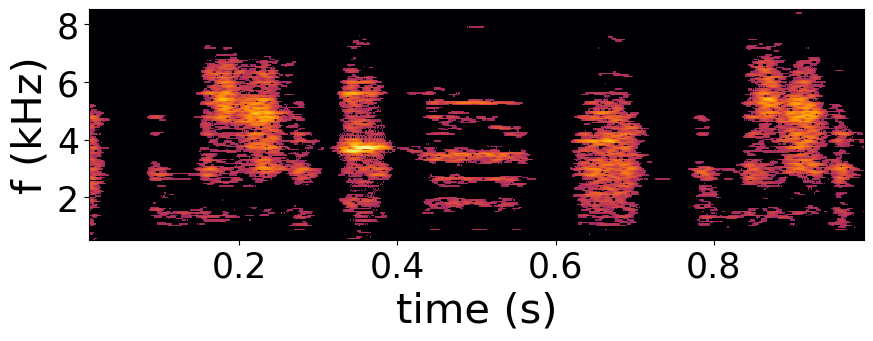

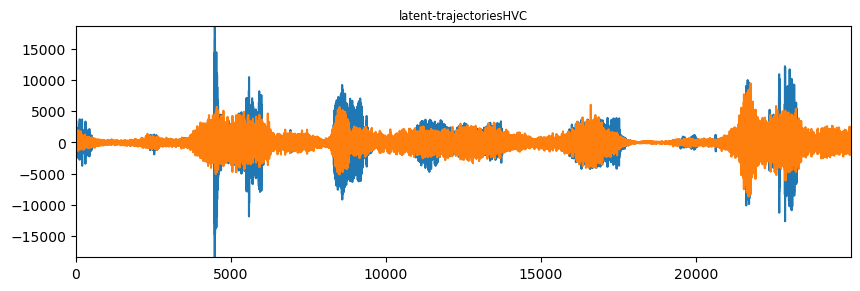

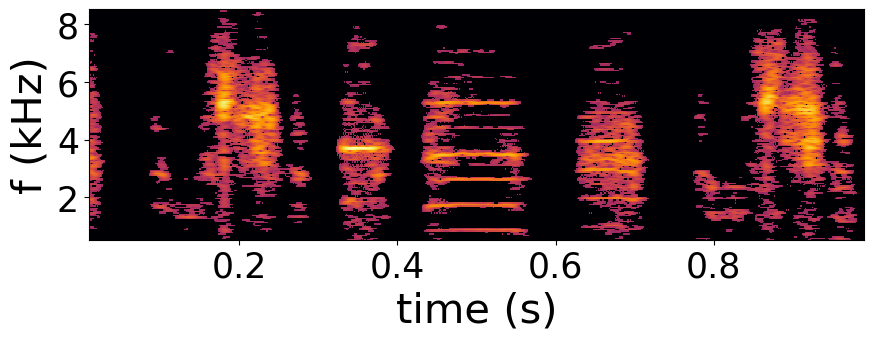

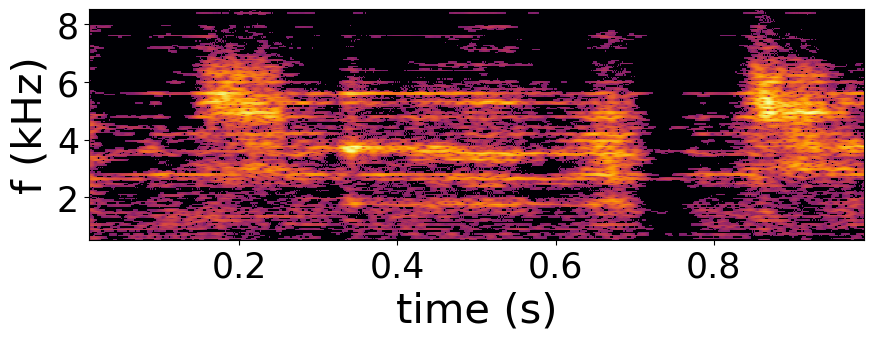

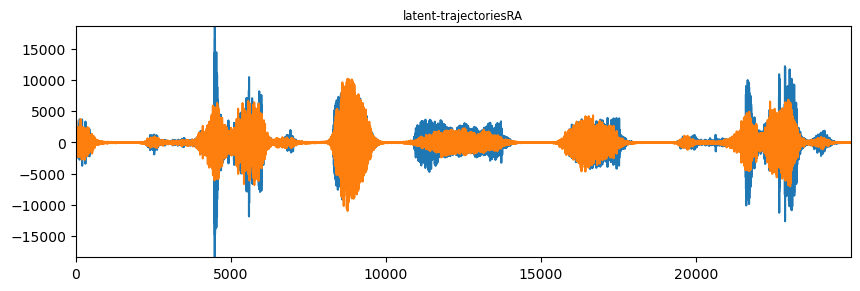

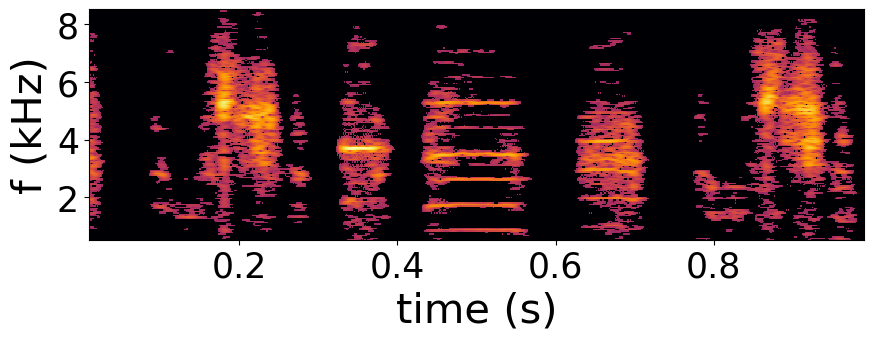

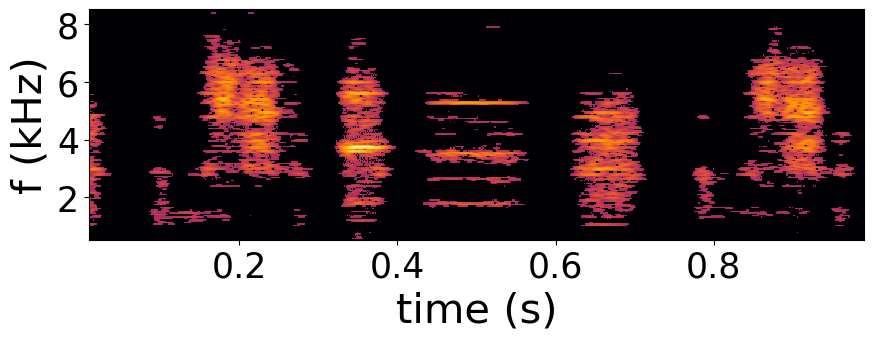

In [6]:
warnings.filterwarnings("ignore")

bird = 'z_w12m7_20'
models_dict = {
    'raw-spiketrains': {
        'HVC': '/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models_checkpoints/ffnn_model_hvc_all_RAW_z_w12m7_20_20240325_210721_config2.pt',
        'RA': '/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models_checkpoints/ffnn_model_ra_all_RAW_z_w12m7_20_20240325_210721_config1.pt'
    },
    
    'latent-trajectories': {
        'HVC': '/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models_checkpoints/ffnn_model_hvc_all_TRAJECTORIES_z_w12m7_20_20240326_201101_config2.pt',
        'RA': '/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models_checkpoints/ffnn_model_ra_all_TRAJECTORIES_z_w12m7_20_20240326_201101_config1.pt'
    }
}


column_names = ['model_name', 'nucleus', 'model', 'Spectrogram reconstruction error']
decoding_accuracy_df = pd.DataFrame(columns=column_names)

for model_type in models_dict:
    for nucleus in models_dict[model_type]:

        # Load model
        model_filename = models_dict[model_type][nucleus]
        print('Loading model: ', model_filename)
        ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict(models_checkpoints_dir, model_filename)

        # Reconstruct spectrogram
        scale = torch.mean(scales)
        original_audio, decoded_audio = get_original_reconstructed_audio(ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scale)

        # Calculate spectrogram reconstruction error
        s1 = su.normalize_signal(au.pretty_spectrogram(original_audio))
        s2 = su.normalize_signal(au.pretty_spectrogram(decoded_audio))
        spec_reconstruction_error = mean_squared_error(s1, s2, multioutput='raw_values')
        
        decoding_accuracy_df.loc[len(decoding_accuracy_df)] = [model_filename, nucleus, model_type, spec_reconstruction_error]

        # Plot original and reconstructed
        # plot_ms = 0.05 + BSP.data[bird]['len_motif'] + 0.05
        plot_ms = 1
        plot_samples = int(plot_ms*fs_audio)
        
        fig, ax = plt.subplots(nrows=1, figsize=(10, 3))
        plt.title(model_type + nucleus)
        plt.plot(original_audio[:plot_samples])
        plt.plot(decoded_audio[:plot_samples])
    
        plot_spectrogram(original_audio, fs_audio, plot_samples)
        plot_spectrogram(decoded_audio, fs_audio, plot_samples)


,model_name,nucleus,model,Spectrogram reconstruction error
0,/home/jovyan/pablo_tostado/bird_song/decoding_...,HVC,raw-spiketrains,"[0.022759688534817517, 0.01656988204201691, 0...."
1,/home/jovyan/pablo_tostado/bird_song/decoding_...,RA,raw-spiketrains,"[0.014257525482861499, 0.005908460035870956, 0..."
2,/home/jovyan/pablo_tostado/bird_song/decoding_...,HVC,latent-trajectories,"[0.02725834454433155, 0.015771999698722585, 0...."
3,/home/jovyan/pablo_tostado/bird_song/decoding_...,RA,latent-trajectories,"[0.015974014453730468, 0.00604819065824626, 0...."


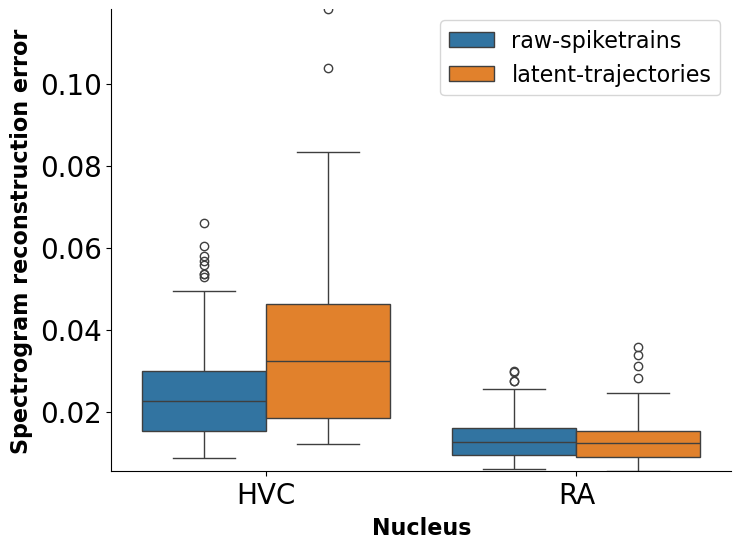

In [7]:
display(decoding_accuracy_df)
error_type = 'Spectrogram reconstruction error'

# Create separate rows for each value in the 'error' list
df_expanded = decoding_accuracy_df.explode(error_type)
# Convert the 'Values' column to numeric
df_expanded[error_type] = pd.to_numeric(df_expanded[error_type])

# Create a box and whisker plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='nucleus', y=error_type, hue='model', data=df_expanded, notch=False)

plt.xlabel('Nucleus', fontsize=16, fontweight='bold')
plt.ylabel(error_type, fontsize=16, fontweight='bold')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust 'labelsize' as needed
plt.legend(fontsize='16') 

plt.show()

Loading model:  /home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models_checkpoints/ffnn_model_hvc_all_RAW_z_r12r13_21_20240328_185716_config2.pt
train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]  - test_ixs:  [37, 38, 39, 40, 41, 42, 43, 44, 45, 46]  - model_layers:  [150, 64, 128]
Length of neural trials: 899.9666666666667 ms, length of audio trials: 899.96 ms. 
Pre-processing neural data as RAW
Using 3 bins of neural data history.
Train samples:  4810
Test samples:  1320
Loading model:  /home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models_checkpoints/ffnn_model_ra_all_RAW_z_r12r13_21_20240328_185716_config1.pt
train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]  - test_ixs:  [37, 38, 39, 40, 41, 42, 43, 44, 45, 46]  - model_layers:  [252, 64, 128]
Length of 

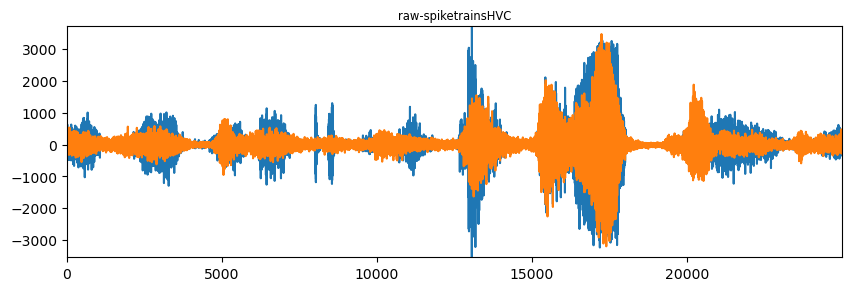

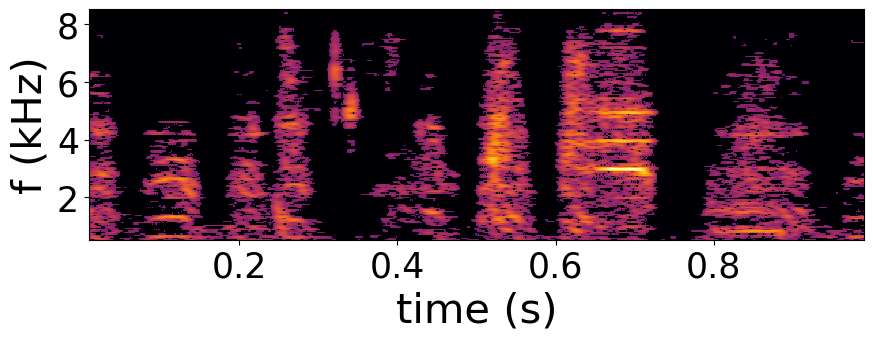

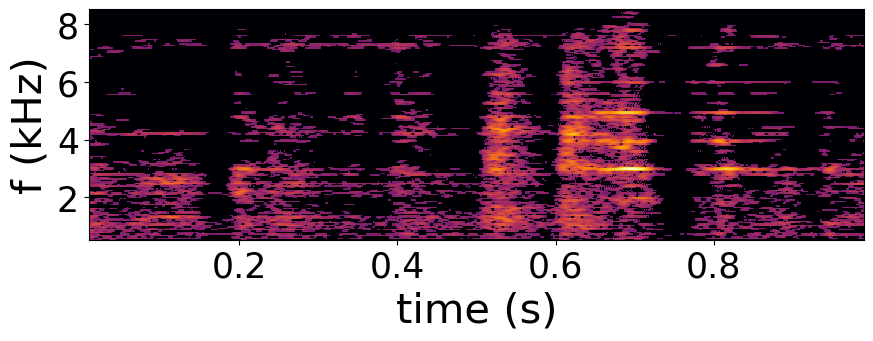

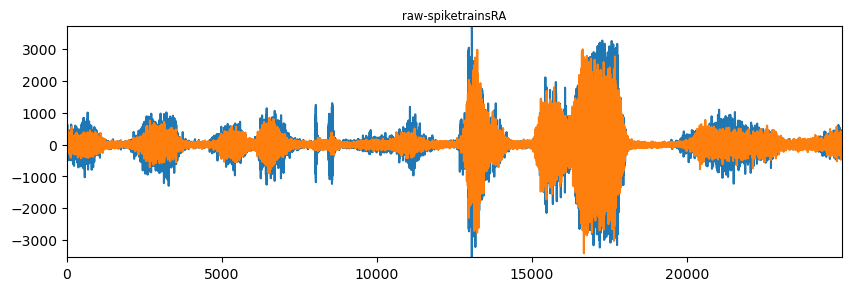

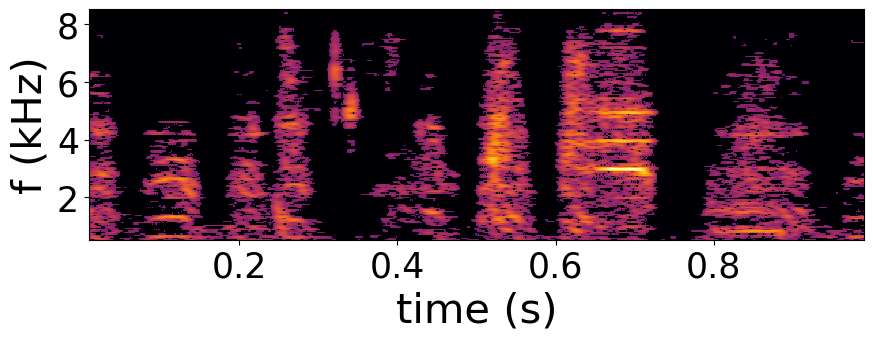

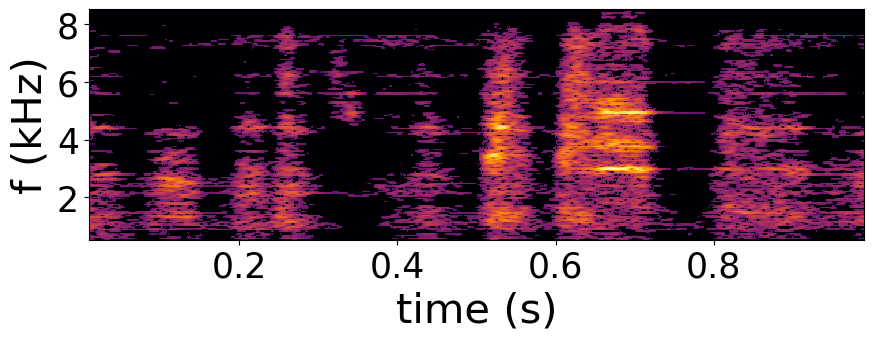

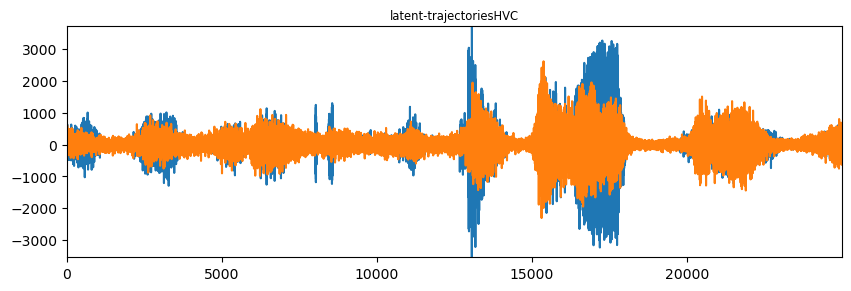

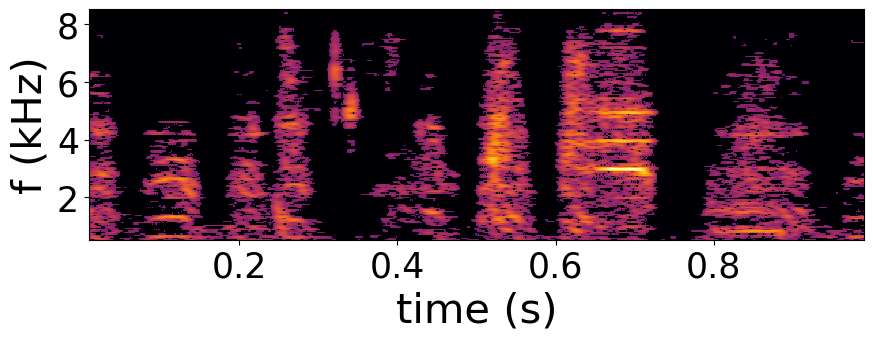

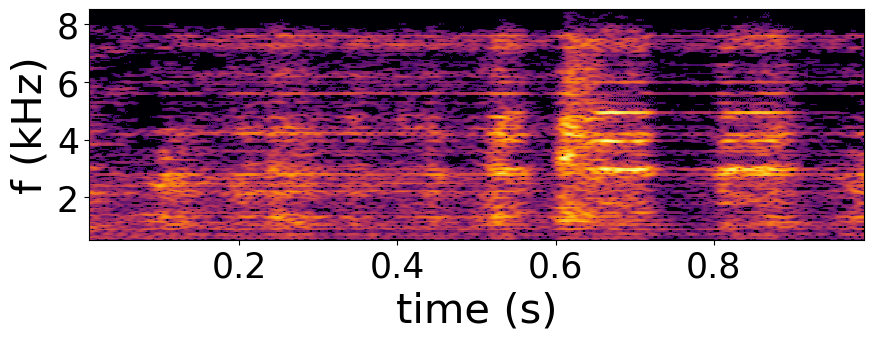

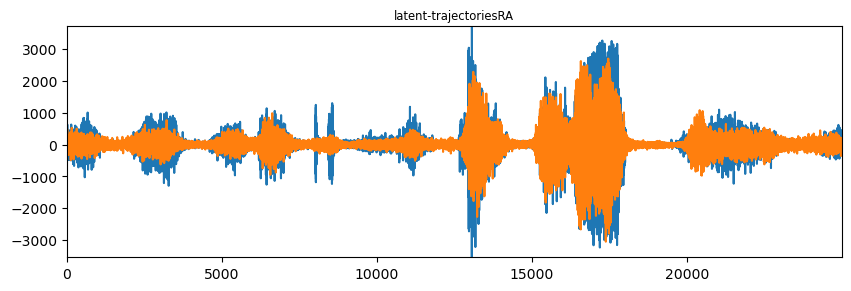

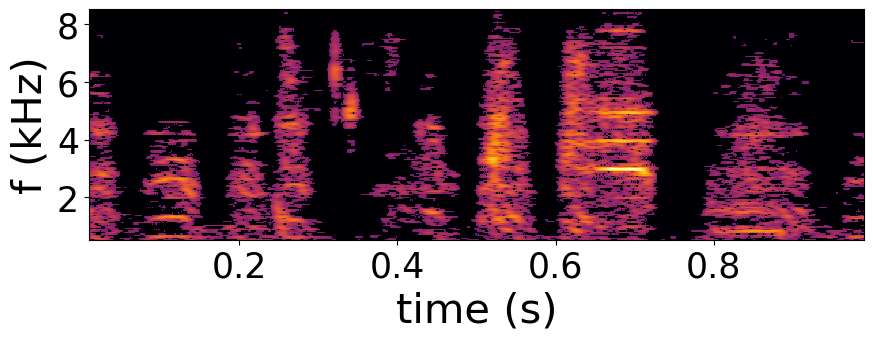

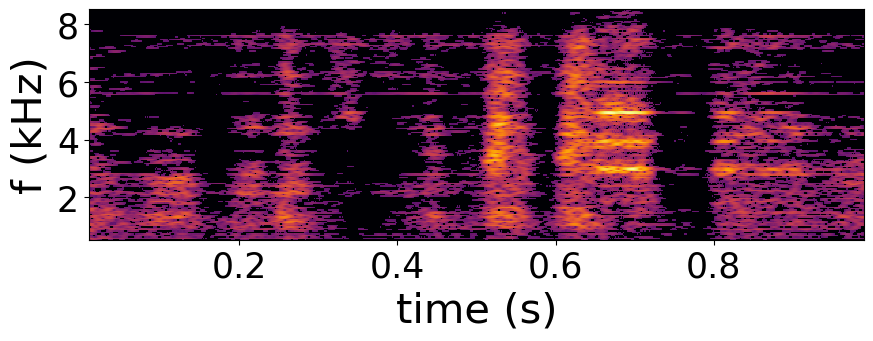

In [8]:
warnings.filterwarnings("ignore")

bird = 'z_r12r13_21'
models_dict = {
    'raw-spiketrains': {
        'HVC': '/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models_checkpoints/ffnn_model_hvc_all_RAW_z_r12r13_21_20240328_185716_config2.pt',
        'RA': '/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models_checkpoints/ffnn_model_ra_all_RAW_z_r12r13_21_20240328_185716_config1.pt'
    },
    
    'latent-trajectories': {
        'HVC': '/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models_checkpoints/ffnn_model_hvc_all_TRAJECTORIES_z_r12r13_21_20240328_191239_config2.pt',
        'RA': '/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models_checkpoints/ffnn_model_ra_all_TRAJECTORIES_z_r12r13_21_20240328_191239_config1.pt'
    }
}


column_names = ['model_name', 'nucleus', 'model', 'Spectrogram reconstruction error']
decoding_accuracy_df = pd.DataFrame(columns=column_names)

for model_type in models_dict:
    for nucleus in models_dict[model_type]:

        # Load model
        model_filename = models_dict[model_type][nucleus]
        print('Loading model: ', model_filename)
        ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict(models_checkpoints_dir, model_filename)

        # Reconstruct spectrogram
        scale = torch.mean(scales)
        original_audio, decoded_audio = get_original_reconstructed_audio(ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scale)

        # Calculate spectrogram reconstruction error
        s1 = su.normalize_signal(au.pretty_spectrogram(original_audio))
        s2 = su.normalize_signal(au.pretty_spectrogram(decoded_audio))
        spec_reconstruction_error = mean_squared_error(s1, s2, multioutput='raw_values')
        
        decoding_accuracy_df.loc[len(decoding_accuracy_df)] = [model_filename, nucleus, model_type, spec_reconstruction_error]

        # Plot original and reconstructed
        # plot_ms = 0.05 + BSP.data[bird]['len_motif'] + 0.05
        plot_ms = 1
        plot_samples = int(plot_ms*fs_audio)
        
        fig, ax = plt.subplots(nrows=1, figsize=(10, 3))
        plt.title(model_type + nucleus)
        plt.plot(original_audio[:plot_samples])
        plt.plot(decoded_audio[:plot_samples])
    
        plot_spectrogram(original_audio, fs_audio, plot_samples)
        plot_spectrogram(decoded_audio, fs_audio, plot_samples)


,model_name,nucleus,model,Spectrogram reconstruction error
0,/home/jovyan/pablo_tostado/bird_song/decoding_...,HVC,raw-spiketrains,"[0.026489315788615367, 0.01740137819391677, 0...."
1,/home/jovyan/pablo_tostado/bird_song/decoding_...,RA,raw-spiketrains,"[0.02221140122455782, 0.009976938413332503, 0...."
2,/home/jovyan/pablo_tostado/bird_song/decoding_...,HVC,latent-trajectories,"[0.03344891418921021, 0.020518534521262163, 0...."
3,/home/jovyan/pablo_tostado/bird_song/decoding_...,RA,latent-trajectories,"[0.02795943446476539, 0.014844074491355724, 0...."


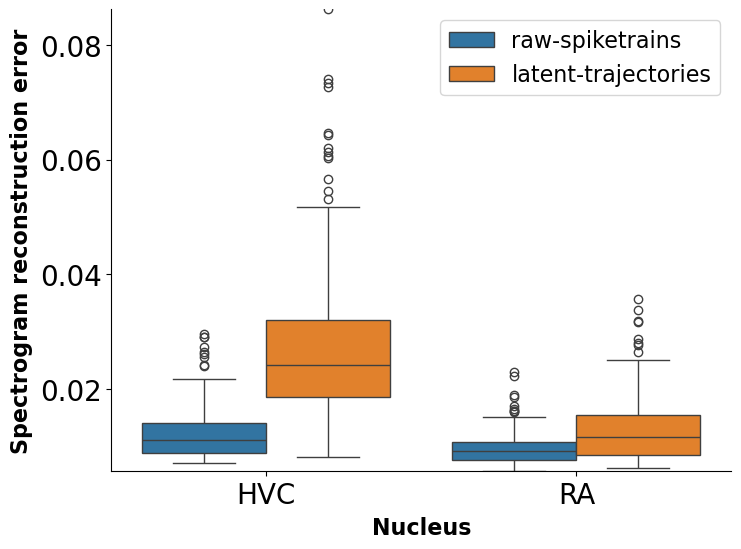

In [10]:
display(decoding_accuracy_df)
error_type = 'Spectrogram reconstruction error'

# Create separate rows for each value in the 'error' list
df_expanded = decoding_accuracy_df.explode(error_type)
# Convert the 'Values' column to numeric
df_expanded[error_type] = pd.to_numeric(df_expanded[error_type])

# Create a box and whisker plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='nucleus', y=error_type, hue='model', data=df_expanded, notch=False)

plt.xlabel('Nucleus', fontsize=16, fontweight='bold')
plt.ylabel(error_type, fontsize=16, fontweight='bold')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust 'labelsize' as needed
plt.legend(fontsize='16') 

plt.show()

In [12]:
s1.shape, s1, s2.shape, s2

((3432, 256),
 array([[0.55693297, 0.51009756, 0.37362164, ..., 0.18228503, 0.12323743,
         0.18588714],
        [0.51412773, 0.35537294, 0.50300394, ..., 0.1097423 , 0.14339424,
         0.12428025],
        [0.51059673, 0.44356937, 0.48973618, ..., 0.09107181, 0.17309235,
         0.15456803],
        ...,
        [0.47542721, 0.43030203, 0.33893517, ..., 0.02582257, 0.06808247,
         0.07425608],
        [0.49562594, 0.4089771 , 0.36453413, ..., 0.06592466, 0.09163257,
         0.03586808],
        [0.50346873, 0.43085885, 0.39727223, ..., 0.18701935, 0.1963434 ,
         0.1866084 ]]),
 (3432, 256),
 array([[0.61083519, 0.62736415, 0.58392886, ..., 0.11939726, 0.01661418,
         0.07638674],
        [0.6287911 , 0.60359062, 0.57297787, ..., 0.        , 0.06309088,
         0.        ],
        [0.61330051, 0.57018139, 0.51751097, ..., 0.16374984, 0.12294087,
         0.15449685],
        ...,
        [0.59031517, 0.53577436, 0.41260564, ..., 0.13467845, 0.07146472,
      